# Sudoku solver 
**Group NO: 07**
* K.M.A.S Kulathunga - 17/ENG/063
* L.T.R.J. Prabodhana - 16/ENG/065
* Y.M.T.L. Yapa - 17/ENG/119

# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from pathlib import Path
from PIL import Image 
from keras import models
import os,random

print("Libraries imported")

Libraries imported


# Help functions


## Print image
**Parameters**


*   image => image readed from imread()
*   title => title for the image



In [ ]:
def printImg(img,title):
  plt.title(title,fontweight = "bold")
  plt.imshow(img)

## Find biggest contour

**Parameters**
* contour => returned from cv2.findContours() function

**returns**
* biggest => return biggest contour
* maxArea => Area of the biggest contour

In [ ]:
def biggestContour(contour):
    biggest = np.array([])
    maxArea = 0

    # iterate through all contours
    for i in contour:
        # calculate the area of i`th contour
        area = cv2.contourArea(i)

        # Remove noises contours(contours that area less than 50)
        if area >50:
            # Calculate the perimeter of the contour
            peri = cv2.arcLength(i, True)
            # Num.of coners contour has
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            # Find the contours that contain only 4 coners (squre or rectangle) and biggest one
            if area > maxArea and len(approx) ==4:
                biggest = approx
                maxArea = area
                
    return biggest ,maxArea

## Re-oder coner points
**Parameters**
* points => points from biggest contour

**return**
* newPoints => reodered points

In [ ]:
def reOderPoints(points):
    points = points.reshape((4, 2))
    newPoints = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    newPoints[0] = points[np.argmin(add)]
    newPoints[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    newPoints[1] = points[np.argmin(diff)]
    newPoints[2] = points[np.argmax(diff)]
    return newPoints

## split cells from the puzzel

In [ ]:
def splitcells(img):
  rows = np.vsplit(img,9)
  cells = []
  for r in rows:
      cols = np.hsplit(r,9)
      for cell in cols:
          cells.append(cell)
  return cells

## Display numbers

In [ ]:
def displayNumbers(img,numbers):
  color = (0,255,0)
  secW = int(img.shape[1]/9)
  secH = int(img.shape[0]/9)
  for x in range (0,9):
      for y in range (0,9):
          if numbers[(y*9)+x] != 0 :
                cv2.putText(img, str(numbers[(y*9)+x]),
                              (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                          2, color, 2, cv2.LINE_AA)
  return img

## Sudoku solver

### Next cell
find next cell to be solved.<br>
**Parameter**
* puzzle => np.array() contain the puzzle

**return**
* row,colmn => retrun column and row number
* False => If there is not any cell to fill

In [ ]:
def nextCell(puzzle):
    for i in range(9):
        for j in range(9):
            if puzzle[i][j] == 0:
                return (i, j)
    return False

### Check posibility <br>
**Parameters**
* puzzle => updated sudoku puzzle(np.arra())
* row => row number of the cell going to chek
* col => column number of the cell
* n => value that going to check whether the n is posible to use in the cell or not
<br>

**return**
* True => if n is posible to use inthe puzzle[row][col] cell
* False => n is can not be assign to the puzzle[row][col] cell

In [ ]:
def possible(puzzle,row, col, n):
    for i in range (0,9):
        if puzzle[row][i] == n and row != i:
            return False
    for i in range (0,9):
        if puzzle[i][col] == n and col != i:
            return False
    
    # Separate into sub row and column
    row0 = (row)//3
    col0 = (col)//3
    for i in range(row0*3, row0*3 + 3):
        for j in range(col0*3, col0*3 + 3):
            if puzzle[i][j]==n and (i,j) != (row, col):
                return False
    return True

### solve

In [ ]:
def solve(puzzle):
    val = nextCell(puzzle)
    if val is False:
        return True
    else:
        row, col = val
        for n in range(1,10):
            if possible(puzzle,row, col, n):
                puzzle[row][col]=n
                if solve(puzzle):
                    return True 
                else:
                    puzzle[row][col]=0
        return 

### Print solved puzzle

In [ ]:
def printPuzzle(quiz):
    for row in range(9):
        if row % 3 == 0 and row != 0:
            print("....................")

        for col in range(9):
            if col % 3 == 0 and col != 0:
                print("|", end=" ")

            if col == 8:
                print(quiz[row][col])
            else:
                print(str(quiz[row][col]) + " ", end="")

# Digits classification model

## Loading pre-trained model

In [ ]:
# Pre-trained model to classify digits
modelPath = "/content/drive/MyDrive/Academic/7th Sem/Computer Vision/Mini project/model for digits/digitClassifier.h5"
model = models.load_model(modelPath)

# Preprocess input image

## Read image

(512, 481, 3)


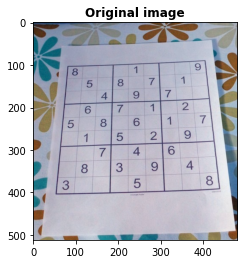

In [ ]:
# path of the Sudoku puzzle image to solve
imgPath = "/content/drive/MyDrive/Academic/7th Sem/Computer Vision/Mini project/WhatsApp.jpeg"
#imgPath = "/content/drive/MyDrive/Academic/7th Sem/Computer Vision/Mini project/hard/input2.PNG"
img = cv2.imread(imgPath)
print(img.shape)
printImg(img,"Original image")

## preprocess

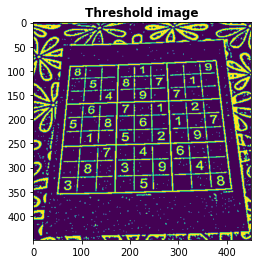

In [ ]:
widthImg = 450
heightImg = 450

blankImg = np.zeros((widthImg,heightImg,3), np.uint8)

# Resize the image to fix size
img = cv2.resize(img, (widthImg,heightImg))

# convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

# Add some blur to image to insert threshold function
blur = cv2.GaussianBlur(gray, (5, 5), 1) 
#blur = cv2.bilateralFilter(gray,9,75,75)
thresholdImg = cv2.adaptiveThreshold(blur,255,1,1,11,2)

printImg(thresholdImg, "Threshold image")

## Detect contours

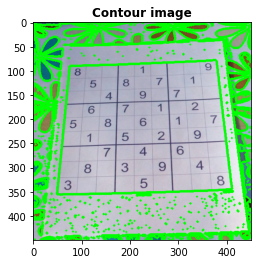

In [ ]:
# creat copy of input images to save contours
contour1 = img.copy()
contour2 = img.copy()

contour, hierarchy = cv2.findContours(thresholdImg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour1,contour,-1,(0,255,0),3)

printImg(contour1,"Contour image")

## Extract the puzzle (Apply perspective transform)

In [ ]:
def Prep(img):
  #making image grayscale
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 

  #Histogram equalization to enhance contrast
  img = cv2.equalizeHist(img) 
  img = img/255 #normalizing
  return img

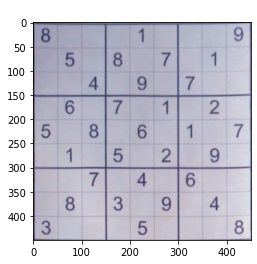

In [ ]:
biggest,maxArea = biggestContour(contour)

if biggest.size != 0:
  biggest = reOderPoints(biggest)
  cv2.drawContours(contour2,biggest,-1, (0,255,0),10)
  pointSet1 = np.float32(biggest)
  pointSet2 = np.float32([[0,0],[widthImg,0],[0,heightImg],[widthImg,heightImg]])
  matrix = cv2.getPerspectiveTransform(pointSet1,pointSet2)  
  imagewrap = cv2.warpPerspective(img,matrix,(450,450)).astype('uint8')
  #ret,thresh1 = cv2.threshold(imagewrap,140,255,cv2.THRESH_BINARY)

printImg(imagewrap," ")


## Extract cells from puzzle

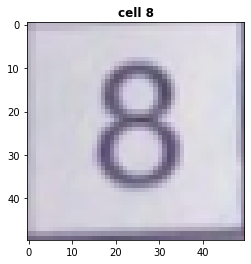

In [ ]:
cells = splitcells(imagewrap)

# Print cell 8
printImg(cells[80],"cell 8")

## Crop cells to remove boders

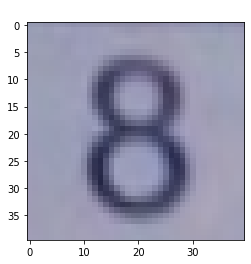

In [ ]:
croppedCells = []
for cell in cells: 
  img1 = np.array(cell)
  img1 = img1[6:46, 6:46]
  img1 = Image.fromarray(img1)
  croppedCells.append(img1)


cellNum = 0
cellToDisplay = croppedCells[cellNum]

printImg(cellToDisplay," ")


# Copy numbers from photo to list

## Read cells

In [ ]:
sudokuList = []

# Detect digit of all cells and store a list
for cell in croppedCells:
  pic = np.asarray(cell)
  pic = cv2.resize(pic, (28, 28))
  pic = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY) 
  pic = pic.astype("float") / 255.0
  pic = pic.reshape(1,28,28,1)

  predictions = model.predict(pic)
  classIndex = model.predict_classes(pic)
  probabilityValue = np.amax(predictions)

  if probabilityValue > 0.7:
    sudokuList.append(np.argmax(predictions, axis=1)[0])
  else:
    sudokuList.append(0)

#sudokuList.append(pred)

#print(predictions,classIndex,probabilityValue)
print(sudokuList)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[8, 0, 0, 0, 1, 0, 0, 0, 9, 0, 5, 0, 8, 0, 7, 0, 1, 0, 0, 0, 4, 0, 9, 0, 7, 0, 0, 0, 6, 0, 7, 0, 1, 0, 2, 0, 5, 0, 8, 0, 6, 0, 1, 0, 7, 0, 1, 0, 5, 0, 2, 0, 9, 0, 0, 0, 7, 0, 4, 0, 6, 0, 0, 0, 8, 0, 3, 0, 9, 0, 4, 0, 3, 0, 0, 0, 5, 0, 0, 0, 8]


# Solve the puzzle

## Print puzzle befor solve

In [ ]:
puzzle = np.reshape(sudokuList,(9,9))
#print(puzzle)

for i in puzzle:
  for j in i:
    print(j,end=" ")
  print()

8 0 0 0 1 0 0 0 9 
0 5 0 8 0 7 0 1 0 
0 0 4 0 9 0 7 0 0 
0 6 0 7 0 1 0 2 0 
5 0 8 0 6 0 1 0 7 
0 1 0 5 0 2 0 9 0 
0 0 7 0 4 0 6 0 0 
0 8 0 3 0 9 0 4 0 
3 0 0 0 5 0 0 0 8 


## Solve puzzle and print

In [ ]:
solvedPuzzle = puzzle.copy()

# Solve the puzzle
if solve(solvedPuzzle):
    printPuzzle(solvedPuzzle)
else:
    print("Solution don't exist. Model misread digits.")

8 7 2 | 4 1 3 | 5 6 9
9 5 6 | 8 2 7 | 3 1 4
1 3 4 | 6 9 5 | 7 8 2
....................
4 6 9 | 7 3 1 | 8 2 5
5 2 8 | 9 6 4 | 1 3 7
7 1 3 | 5 8 2 | 4 9 6
....................
2 9 7 | 1 4 6 | 6 5 3
6 8 5 | 3 7 9 | 2 4 1
3 4 1 | 2 5 8 | 9 7 8


# Overlay solution to the input image

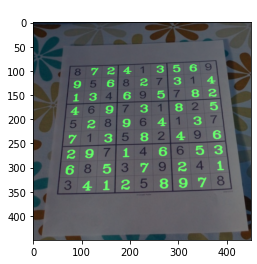

In [ ]:
flatList = []

# convert 2d array to 1d and only add solutions to array
for i in range(9):
  for j in range(9):
    if puzzle[i][j] == 0:
      flatList.append(solvedPuzzle[i][j])
    else:
      flatList.append(0)

solvedImage = blankImg.copy()

solvedImage = displayNumbers(solvedImage,flatList)

pointSet1 = np.float32(biggest)
pointSet2 = np.float32([[0,0],[widthImg,0],[0,heightImg],[widthImg,heightImg]])
matrix1 = cv2.getPerspectiveTransform(pointSet2,pointSet1) 

solutionInOutput = img.copy()
img2 = img.copy()
img2 = cv2.resize(img2, (widthImg, heightImg))
solutionInOutput = cv2.warpPerspective(solvedImage,matrix1,(widthImg,heightImg))
outputImg = cv2.addWeighted(solutionInOutput,1,img2,0.5,1)

printImg(outputImg," ")